<a href="https://www.kaggle.com/code/enricofindley/red-wine-quality-prediction-using-regression-tree?scriptVersionId=138328101" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.metrics import accuracy_score
from math import sqrt
import matplotlib.pyplot as plt
from imblearn.combine import SMOTETomek
from sklearn.model_selection import KFold, cross_val_score
from sklearn import tree

from six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
!pip install pydotplus
import pydotplus

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.7/278.7 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24576 sha256=6bbc577f5586d3d178d24cba1b4274d0d1c93fbb59878150ff357b9e8fd95d7d
  Stored in directory: /root/.cache/pip/wheels/69/b2/67/08f0eef649af92df772c09f451558298e07fab1bc7cdf33db0
Successfully built pydotplus


# Reading the data

In [2]:
url = "/kaggle/input/red-wine-quality-cortez-et-al-2009/winequality-red.csv"
data = pd.read_csv(url)

In [3]:
data.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5  
3      9.8        6  
4      9.4        5

In [4]:
data.shape

(1599, 12)

# Selecting the input and output features for regression tasks

In [5]:
features = ['fixed acidity','volatile acidity','citric acid','residual sugar','chlorides',
            'free sulfur dioxide','total sulfur dioxide','density','pH','sulphates','alcohol']

In [6]:
target = ['quality']

# Checking for any null values in the dataset

In [7]:
data.isnull().any()

fixed acidity           False
volatile acidity        False
citric acid             False
residual sugar          False
chlorides               False
free sulfur dioxide     False
total sulfur dioxide    False
density                 False
pH                      False
sulphates               False
alcohol                 False
quality                 False
dtype: bool

# Normalize Dataset

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
normal_df = scaler.fit_transform(data.iloc[:,0:-1])
normal_df = pd.DataFrame(normal_df, columns = data.iloc[:,0:-1].columns)
print(normal_df.head())

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0       0.247788          0.397260         0.00        0.068493   0.106845   
1       0.283186          0.520548         0.00        0.116438   0.143573   
2       0.283186          0.438356         0.04        0.095890   0.133556   
3       0.584071          0.109589         0.56        0.068493   0.105175   
4       0.247788          0.397260         0.00        0.068493   0.106845   

   free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
0             0.140845              0.098940  0.567548  0.606299   0.137725   
1             0.338028              0.215548  0.494126  0.362205   0.209581   
2             0.197183              0.169611  0.508811  0.409449   0.191617   
3             0.225352              0.190813  0.582232  0.330709   0.149701   
4             0.140845              0.098940  0.567548  0.606299   0.137725   

    alcohol  
0  0.153846  
1  0.215385  
2  0.215385  


# Fixing Imbalanced Dataset

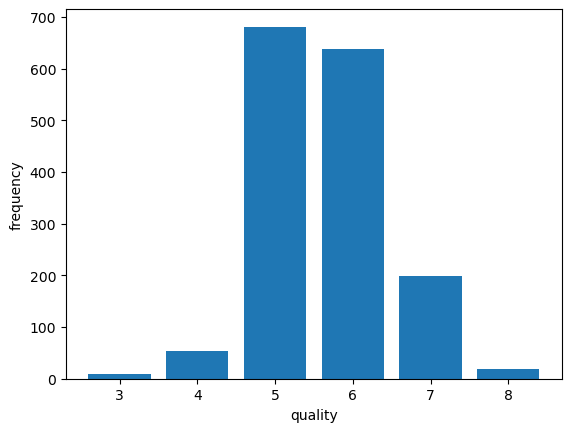

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64


In [9]:
quality_dist = data['quality'].value_counts()
plt.bar(quality_dist.index, quality_dist)
plt.xlabel('quality')
plt.ylabel('frequency')
plt.show()
print(quality_dist)

In [10]:
data['quality'] = data['quality'].map({
        3 : 0,
        4 : 0,
        5 : 1,
        6 : 1,
        7 : 2,
        8 : 2         
})

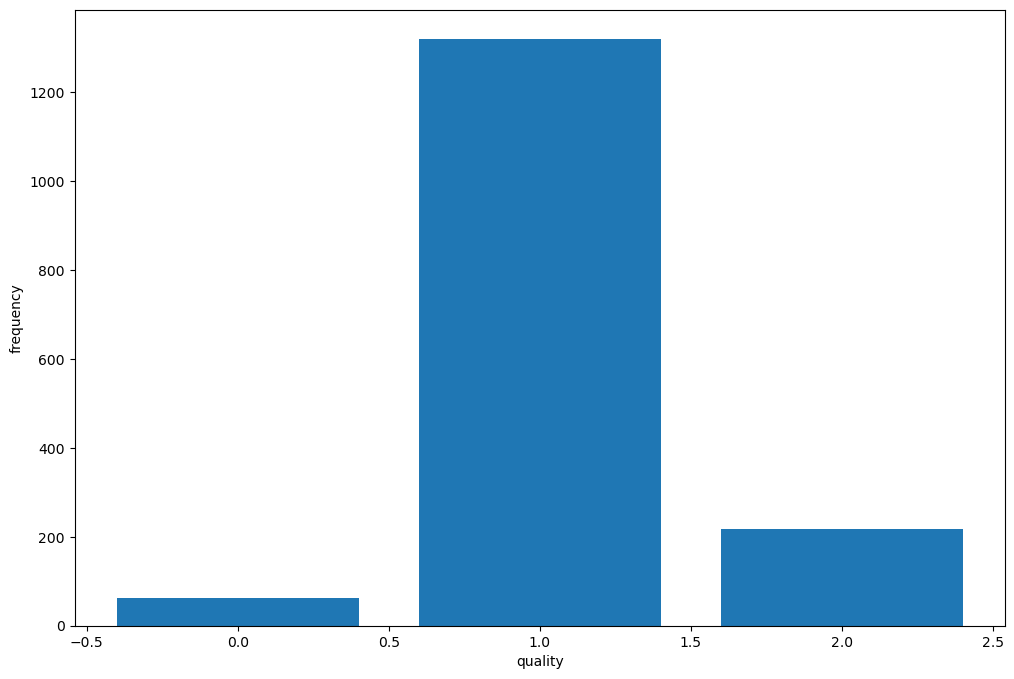

1    1319
2     217
0      63
Name: quality, dtype: int64


In [11]:
fig, ax = plt.subplots(figsize=(12,8))
quality_dist = data['quality'].value_counts()
plt.bar(quality_dist.index, quality_dist)
plt.xlabel('quality')
plt.ylabel('frequency')
plt.show()
print(quality_dist)

In [12]:
sme = SMOTETomek(random_state=42)
X_resampled, y_resampled = sme.fit_resample(normal_df, data['quality'])

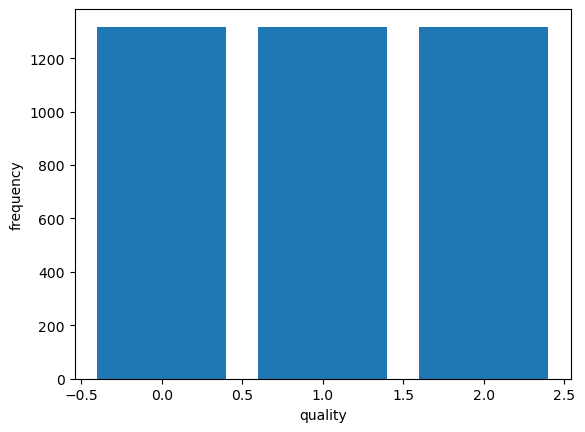

2    1318
0    1317
1    1316
Name: quality, dtype: int64


In [13]:
quality_dist = y_resampled.value_counts()
plt.bar(quality_dist.index, quality_dist)
plt.xlabel('quality')
plt.ylabel('frequency')
plt.show()
print(quality_dist)

In [14]:
class Percent(float):
    def __str__(self):
        return '{:.2%}'.format(self)

# Perform K-fold Cross Validation

In [15]:
maxDeep = [3,6,9,12,15]

kf = KFold(n_splits=5, random_state=67, shuffle=True)
kf.get_n_splits(X_resampled,y_resampled)

print(kf)
print(maxDeep)

modelIndex = 1
for train_index, test_index in kf.split(X_resampled):
    print("---------------------------")
    print("MODEL", modelIndex)
    X_train, X_test = X_resampled.iloc[train_index], X_resampled.iloc[test_index]
    y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]
    print("train vs test",Percent((len(X_train)/(len(X_resampled)))),len(X_train),Percent((len(X_test)/(len(X_resampled)))),len(X_test))
    for n in maxDeep :
      print("maxDeep", n)
      regressor = tree.DecisionTreeRegressor(max_depth=n)
      regressor = regressor.fit(X_train, y_train)
      regressor_predict = regressor.predict(X_test)
      print("RMSE:",sqrt(mean_squared_error(y_true=y_test, y_pred=regressor_predict)))
      print("MSE:",mean_squared_error(y_true=y_test, y_pred=regressor_predict))   
      print("MAE:",mean_absolute_error(y_true=y_test, y_pred=regressor_predict))
    modelIndex=modelIndex+1


KFold(n_splits=5, random_state=67, shuffle=True)
[3, 6, 9, 12, 15]
---------------------------
MODEL 1
train vs test 79.98% 3160 20.02% 791
maxDeep 3
RMSE: 0.529838894935456
MSE: 0.2807292545864252
MAE: 0.44060386292036735
maxDeep 6
RMSE: 0.4325930803296495
MSE: 0.18713677314909458
MAE: 0.2925865961667717
maxDeep 9
RMSE: 0.3727667327395573
MSE: 0.13895503703732454
MAE: 0.19109085363114367
maxDeep 12
RMSE: 0.39425992634605195
MSE: 0.15544088952239432
MAE: 0.1585184843720964
maxDeep 15
RMSE: 0.36530026527203513
MSE: 0.13344428380781925
MAE: 0.13048980654208583
---------------------------
MODEL 2
train vs test 80.01% 3161 19.99% 790
maxDeep 3
RMSE: 0.5087801759487504
MSE: 0.25885726743844134
MAE: 0.42001631612371787
maxDeep 6
RMSE: 0.4071203728143432
MSE: 0.1657469979604898
MAE: 0.28598793207388984
maxDeep 9
RMSE: 0.3831413130595779
MSE: 0.14679726577301747
MAE: 0.21101826779770744
maxDeep 12
RMSE: 0.3686835847551451
MSE: 0.13592758566790428
MAE: 0.1535309855599266
maxDeep 15
RMSE: 0.3658

### Retrain Model On Whole Dataset

In [16]:
regressor = regressor.fit(X_resampled, y_resampled)
regressor_predict = regressor.predict(X_test)

# Display Final Tree

In [17]:
def makeTree(regs):
  treeGrasps = []
  dot_data = StringIO()
  export_graphviz(regs, out_file=dot_data,  
                  filled=True, rounded=True,
                  special_characters=True, feature_names = features)
  graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
  treeGrasps.append(graph)
  return treeGrasps

treeGrasps= makeTree(regressor)


In [18]:
treeGrasps[0].write_png('wine quality.png')
Image(treeGrasps[0].create_png())